In [1]:
import os
import openai

In [2]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

### Load and Analyse data

In [6]:
df = pd.read_csv("data/imdb_dataset.csv")

In [7]:
df["review_length"] = df["review"].agg(len)

/var/folders/zg/9b190f8115751ghz2zn9fj8m0000gn/T/ipykernel_8317/321584826.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


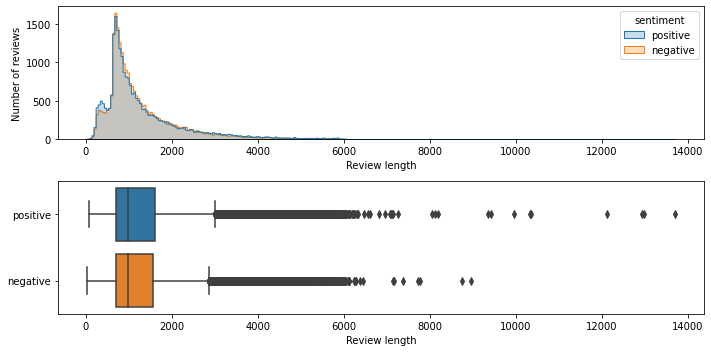

In [8]:
fig, ax = plt.subplots(2, figsize=(10, 5))
sns.histplot(x=df["review_length"], hue=df["sentiment"], element="step", ax=ax[0])
sns.boxplot(x=df["review_length"], y=df["sentiment"], ax=ax[1])
ax[0].set_ylabel("Number of reviews")
ax[0].set_xlabel("Review length")
ax[1].set_ylabel(None)
ax[1].set_xlabel("Review length")
fig.tight_layout()
fig.show()

### create fake dataset

In [9]:
MIN_REVIEW_LENGTH = 0
MAX_REVIEW_LENGTH = 500

In [10]:
POSITIVE_PERCENTAGE = 0.01
NEGATIVE_PERCENTAGE = 0.5

In [11]:
input_df = pd.concat([
    df.query("sentiment == 'positive'").sample(frac=POSITIVE_PERCENTAGE, random_state=0),
    df.query("sentiment == 'negative'").sample(frac=NEGATIVE_PERCENTAGE, random_state=0)
])
input_df = input_df[input_df["review_length"].between(MIN_REVIEW_LENGTH, MAX_REVIEW_LENGTH)]

In [12]:
input_df["sentiment"].value_counts()

negative    1156
positive      28
Name: sentiment, dtype: int64

/var/folders/zg/9b190f8115751ghz2zn9fj8m0000gn/T/ipykernel_88210/2525592935.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


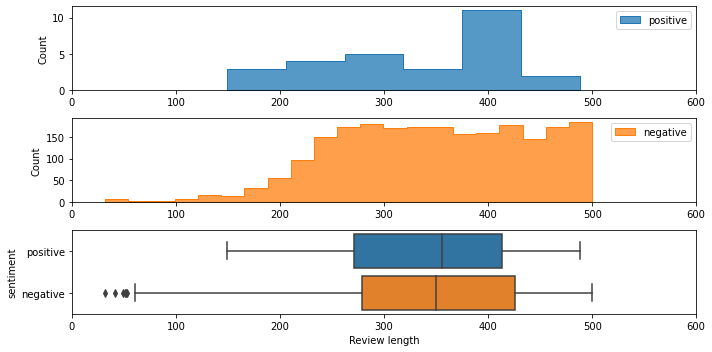

In [309]:
fig, ax = plt.subplots(3, figsize=(10, 5))
sns.histplot(x=input_df.query("sentiment == 'positive'")["review_length"], color=sns.color_palette()[0], label="positive", element="step", ax=ax[0])
sns.histplot(x=input_df.query("sentiment == 'negative'")["review_length"], color=sns.color_palette()[1], label="negative", element="step", ax=ax[1])
sns.boxplot(x=input_df["review_length"], y=input_df["sentiment"], ax=ax[2])

step = 100
common_x_ticks =np.arange(MIN_REVIEW_LENGTH, MAX_REVIEW_LENGTH+2*step, step)
ax[0].set_xticks(common_x_ticks)
ax[1].set_xticks(common_x_ticks)
ax[2].set_xticks(common_x_ticks)

ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[2].set_xlabel("Review length")

ax[0].legend()
ax[1].legend()

fig.tight_layout()
fig.show()

### Generate synthetic data

In [331]:
prompt = "Text: " + "\nText: ".join(input_df.query("sentiment == 'positive'").review) + "\nText:"

In [333]:
print(prompt)

Text: The first time you see The Second Renaissance it may look boring. Look at it at least twice and definitely watch part 2. It will change your view of the matrix. Are the human people the ones who started the war ? Is AI a bad thing ?
Text: Throw Momma hasn't dated at all, it's as funny now as when it was released. A genuinely eccentric comedy, that doesn't try too hard to be liked and is all the better for it, full of memorable laugh out loud lines. Even small characters are well written and beautifully played, like Billy Crystal's best friend's girlfriend, and a lovely cameo from Rob Reiner as Crystal's agent. A little bit insane and a lot funny.
Text: Leon was fantastic as always, this time playing Little Richard in his early years. The movie showed a fully fleshed out Little Richard without neglecting to fill the show with lots of great music. My only complaint is that the ending was a little abrupt - I was hoping for a 2-parter!
Text: This was a very strong look at prejudice a

In [318]:
response = openai.Completion.create(
    engine="davinci", 
    prompt=prompt, 
    max_tokens=MAX_REVIEW_LENGTH,
    temperature=0.5,
    stop=["Text:"],
    n=5
)

### Find similarity to all training examples

In [319]:
from fuzzywuzzy import fuzz

In [330]:
similarity_scores = []
generated_lengths = []
length_differences = []

for response_dict in response["choices"]:
    cur_similarity_scores = []
    cur_length_differences = []

    gen_text = response_dict["text"]
    print(gen_text)
    for train_text in input_df["review"]:
        cur_similarity_scores.append(fuzz.partial_ratio(train_text, gen_text))
        cur_length_differences.append(len(train_text) - len(gen_text))
        
    generated_lengths.append(len(gen_text))
    similarity_scores.append(cur_similarity_scores)
    length_differences.append(cur_length_differences)

 A young woman is kidnapped and taken to a remote cabin in the woods. While there, she befriends a man who is chained to the wall.<br /><br />He tells her that he is her husband, and that they were on their honeymoon when they were kidnapped by a group of people who are performing twisted experiments on them.<br /><br />She soon learns that she must escape, or risk becoming a victim of the same atrocities.<br /><br />This is a very good movie with a very good ending.

 A very funny short, which is essentially a parody of the "Bugs Bunny" shorts of the 40's and 50's. Bugs Bunny is replaced by "Henry", a bald, portly boy that never speaks, but all the other characters are there, including Elmer Fudd.

 This movie is hilarious. It's about a guy who can't get a date, so he goes to a bar and meets a girl who is a space alien. The movie is hilarious because the guy is so stupid.

 This is a great movie for all ages. It is a must see movie. I love the actors and actresses in this movie. The m

In [327]:
similarity_scores

[[32, 19, 15, 14, 21],
 [24, 23, 26, 23, 26],
 [28, 25, 30, 32, 34],
 [34, 35, 32, 21, 33],
 [30, 35, 24, 30, 23]]

In [328]:
length_differences

[[-296, -197, -126, -43, -18],
 [-59, 40, 111, 194, 219],
 [-1, 98, 169, 252, 277],
 [-91, 8, 79, 162, 187],
 [-34, 65, 136, 219, 244]]

In [329]:
generated_lengths

[472, 235, 177, 267, 210]

### Find similarity to other generated examples

In [365]:
similarity_scores = []

for i, response_dict_1 in enumerate(response["choices"]):
    cur_similarity_scores = []
    gen_text = response_dict_1["text"]
    print(gen_text)
    for j, response_dict_2 in enumerate(response["choices"]):
        if i == j:
            continue
        comparison_gen_text = response_dict_2["text"]
        cur_similarity_scores.append(fuzz.partial_ratio(comparison_gen_text, gen_text))
    similarity_scores.append(cur_similarity_scores)

 A young woman is kidnapped and taken to a remote cabin in the woods. While there, she befriends a man who is chained to the wall.<br /><br />He tells her that he is her husband, and that they were on their honeymoon when they were kidnapped by a group of people who are performing twisted experiments on them.<br /><br />She soon learns that she must escape, or risk becoming a victim of the same atrocities.<br /><br />This is a very good movie with a very good ending.

 A very funny short, which is essentially a parody of the "Bugs Bunny" shorts of the 40's and 50's. Bugs Bunny is replaced by "Henry", a bald, portly boy that never speaks, but all the other characters are there, including Elmer Fudd.

 This movie is hilarious. It's about a guy who can't get a date, so he goes to a bar and meets a girl who is a space alien. The movie is hilarious because the guy is so stupid.

 This is a great movie for all ages. It is a must see movie. I love the actors and actresses in this movie. The m

In [366]:
similarity_scores

[[29, 31, 25, 34],
 [29, 27, 25, 10],
 [31, 27, 34, 32],
 [25, 25, 34, 7],
 [34, 10, 32, 7]]

# Model pipleine

In [382]:
list(df)

['review', 'sentiment', 'review_length']

In [387]:
test_df = df[df["review_length"].between(0, MAX_REVIEW_LENGTH)]
test_df.sentiment.value_counts()

positive    2743
negative    2240
Name: sentiment, dtype: int64

In [388]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [375]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()
pipeline = make_pipeline(vectorizer, classifier)

In [379]:
pipeline.fit(X=input_df["review"], y=input_df["sentiment"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [381]:
prediction = pipeline.predict_proba(X=input_df["review"])